In [1]:
# Portafolio rebalance. EMPRESAS DEL IPC, ULTIMOS 5 años de data.

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [2]:
# Download historical data (monthly) for IPC constituent stocks

tickers = ["BOLSAA.MX","AC.MX","TLEVISACPO.MX","ASURB.MX","GENTERA.MX","OMAB.MX","CUERVO.MX","FEMSAUBD.MX"
           ,"CEMEXCPO.MX","GAPB.MX","BIMBOA.MX","GCARSOA1.MX","GFNORTEO.MX","ALSEA.MX","LABB.MX","MEGACPO.MX",
           "GRUMAB.MX","GMEXICOB.MX"]

ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data
print(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
# Resultados del indice IPC solo, se va a utilizar un ETF que busca replicar el indice. NAFTRACISHRS.MX

#calculating KPIs for Index buy and hold strategy over the same period
IPC = yf.download("NAFTRACISHRS.MX",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo')
IPC["mon_ret"] = IPC["Adj Close"].pct_change().fillna(0)
print("CAGR:",CAGR(IPC))
print("Sharpe:",sharpe(IPC,0.025))
print("Max dd:",max_dd(IPC))

[*********************100%%**********************]  1 of 1 completed
CAGR: 0.03966083053661462
Sharpe: 0.09028187046508943
Max dd: 0.3231100440993471


In [4]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

calculating monthly return for  BOLSAA.MX
calculating monthly return for  AC.MX
calculating monthly return for  TLEVISACPO.MX
calculating monthly return for  ASURB.MX
calculating monthly return for  GENTERA.MX
calculating monthly return for  OMAB.MX
calculating monthly return for  CUERVO.MX
calculating monthly return for  FEMSAUBD.MX
calculating monthly return for  CEMEXCPO.MX
calculating monthly return for  GAPB.MX
calculating monthly return for  BIMBOA.MX
calculating monthly return for  GCARSOA1.MX
calculating monthly return for  GFNORTEO.MX
calculating monthly return for  ALSEA.MX
calculating monthly return for  LABB.MX
calculating monthly return for  MEGACPO.MX
calculating monthly return for  GRUMAB.MX
calculating monthly return for  GMEXICOB.MX


In [5]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        #print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df


#calculating overall strategy's KPIs
print(CAGR(pflio(return_df,6,3)))
print(sharpe(pflio(return_df,6,3),0.025))
print(max_dd(pflio(return_df,6,3))) 
print(return_df.tail)


0.03491768364941472
0.04315645865862802
0.36411237852758044
<bound method NDFrame.tail of             BOLSAA.MX     AC.MX  TLEVISACPO.MX  ASURB.MX  GENTERA.MX  \
Date                                                                   
2017-04-01   0.055430  0.067410      -0.058065  0.098935    0.023346   
2017-05-01  -0.026565 -0.040325      -0.012482  0.028666   -0.049113   
2017-06-01   0.033260  0.038280      -0.015571  0.042073   -0.092636   
2017-07-01  -0.034037 -0.032334       0.072810  0.010113    0.007971   
2017-08-01   0.008483 -0.008941      -0.025819 -0.040868    0.013299   
...               ...       ...            ...       ...         ...   
2023-09-01  -0.043669 -0.046426      -0.307339 -0.079931   -0.015407   
2023-10-01  -0.139749  0.018958      -0.223273 -0.086758   -0.066015   
2023-11-01   0.175632  0.094697       0.354446  0.051385    0.049215   
2023-12-01   0.063939  0.057509       0.024281  0.247831    0.181138   
2024-01-01  -0.047280 -0.021409      -0.166813

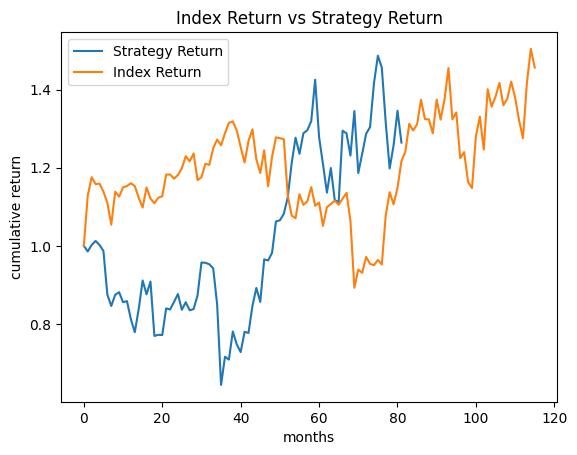

In [6]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+IPC["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])